In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-area-segmentation/metadata.csv
/kaggle/input/flood-area-segmentation/Mask/1017.png
/kaggle/input/flood-area-segmentation/Mask/2015.png
/kaggle/input/flood-area-segmentation/Mask/1084.png
/kaggle/input/flood-area-segmentation/Mask/2021.png
/kaggle/input/flood-area-segmentation/Mask/1012.png
/kaggle/input/flood-area-segmentation/Mask/48.png
/kaggle/input/flood-area-segmentation/Mask/3012.png
/kaggle/input/flood-area-segmentation/Mask/1037.png
/kaggle/input/flood-area-segmentation/Mask/2009.png
/kaggle/input/flood-area-segmentation/Mask/1023.png
/kaggle/input/flood-area-segmentation/Mask/3070.png
/kaggle/input/flood-area-segmentation/Mask/37.png
/kaggle/input/flood-area-segmentation/Mask/1048.png
/kaggle/input/flood-area-segmentation/Mask/3068.png
/kaggle/input/flood-area-segmentation/Mask/1000.png
/kaggle/input/flood-area-segmentation/Mask/35.png
/kaggle/input/flood-area-segmentation/Mask/2030.png
/kaggle/input/flood-area-segmentation/Mask/1081.png
/kaggle/input/flood

In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, models

In [3]:
pwd

'/kaggle/working'

In [4]:
ls '/kaggle/input/flood-area-segmentation'

Image/  Mask/  metadata.csv


/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
def create_data(data_dir):
    image_paths = []
    mask_paths = []
    
    folds = sorted(os.listdir(data_dir))
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        if fold in ['image', 'Image', 'images', 'Images', 'IMAGES']:
            images = sorted(os.listdir(foldpath))
            for image in images:
                fpath = os.path.join(foldpath, image)
                image_paths.append(fpath)

        elif fold in ['mask', 'Mask', 'masks', 'Masks', 'MASKS']:
            masks = sorted(os.listdir(foldpath))
            for mask in masks:
                fpath = os.path.join(foldpath, mask)
                mask_paths.append(fpath)
        else:
            continue
        
    return image_paths, mask_paths

In [6]:
# function to read an image
def load_image(image, SIZE):
    return np.round(cv2.resize(img_to_array(load_img(image)) / 255., (SIZE, SIZE)), 4)

# function to read multiple images
def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
    
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i, image in enumerate(image_paths):
        img = load_image(image, SIZE)
        if mask:
            images[i] = img[:, :, :1]
        else:
            images[i] = img
    
    return images

In [7]:
SIZE = 256

# get data
data_dir = '/kaggle/input/flood-area-segmentation'
image_paths, mask_paths = create_data(data_dir)

# load images and masks
imgs = load_images(image_paths, SIZE)
msks = load_images(mask_paths, SIZE, mask=True)

In [8]:
print(f'Image: {len(imgs)}, Masks:{len(msks)}')

Image: 290, Masks:290


In [9]:
def get_colored_mask(mask):
    colormap = plt.get_cmap('viridis')  
    colored_mask = colormap(mask.squeeze())
    return colored_mask

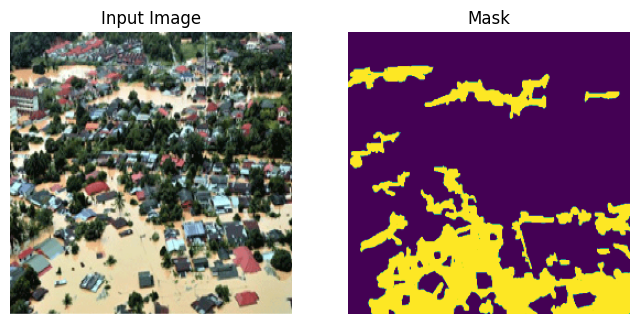

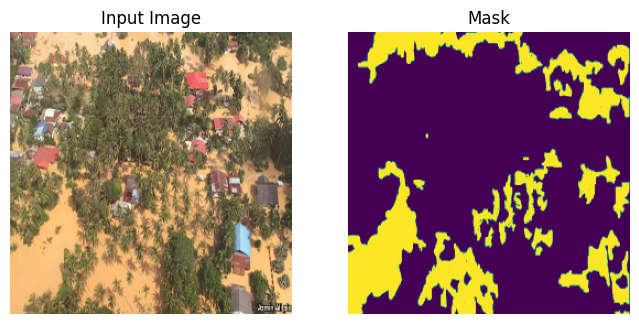

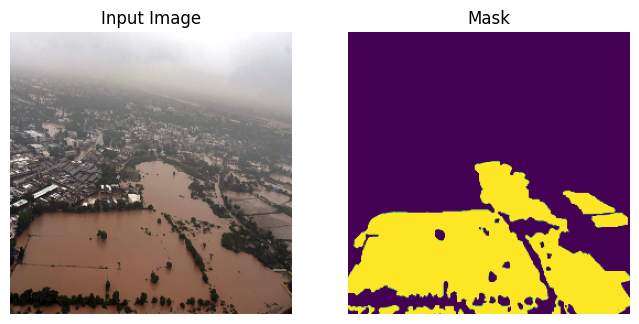

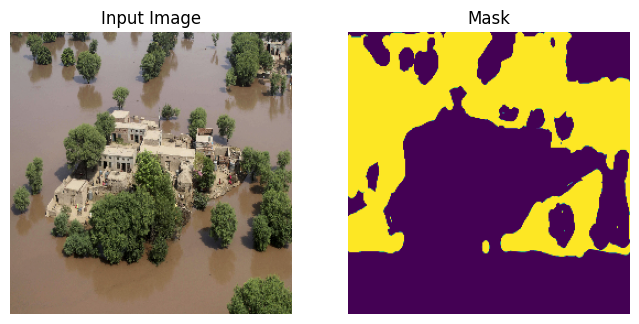

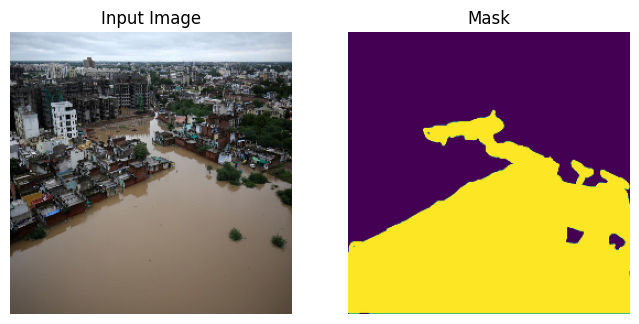

In [10]:
for i in range(5):
    plt.figure(figsize=(8, 6))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    colored_mask = get_colored_mask(msks[i])
    plt.imshow(colored_mask)
    plt.axis('off')
    
    plt.show()

In [11]:
num_train_images = int(len(imgs) * .8)
x_train = imgs[:num_train_images]
y_train = msks[:num_train_images]
x_test = imgs[num_train_images:]
y_test = msks[num_train_images:]

In [12]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4], axis=3)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3], axis=3)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2], axis=3)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [13]:
model = unet_model(input_size=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1536)   │              0 │ up_sampling2d[0][0],   │
│                      

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    x_train,
    y_train,
    batch_size=32, 
    epochs=50
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 197s 10s/step - accuracy: 0.5649 - loss: 0.6909
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6007 - loss: 0.6673
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6921 - loss: 0.6079
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7531 - loss: 0.5379
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7707 - loss: 0.5151
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7604 - loss: 0.5079
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7879 - loss: 0.4537
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8057 - loss: 0.4167
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7875 - loss: 0.4525
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7864 - loss: 0.4456
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8070 - loss: 0.4121
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8002 - loss: 0.4177
Epoch 13/50

In [16]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 84s 39s/step - accuracy: 0.8850 - loss: 0.2530
Test Loss: 0.24079875648021698
Test Accuracy: 0.8905258178710938


In [17]:
predictions = model.predict(x_test)

sample_image = x_test[2]
sample_mask = y_test[2]
sample_prediction = predictions[2]

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 828ms/step


In [18]:
# Convert predictions to binary masks
sample_prediction_binary = (sample_prediction > 0.5).astype(np.float32)

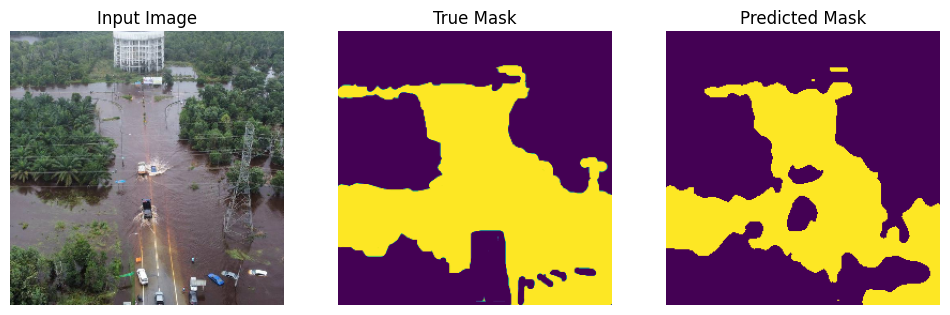

In [19]:
def plot_sample(image, true_mask, pred_mask):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(image)
    
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    colored_mask = get_colored_mask(true_mask)
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    colored_mask = get_colored_mask(pred_mask)
    plt.imshow(colored_mask)
    plt.axis('off')

    plt.show()

# Plot the sample
plot_sample(sample_image, sample_mask, sample_prediction_binary)

In [20]:
model.save('Flood Semantic Segmentation.keras')

In [21]:
from IPython.display import FileLink 
FileLink(r'/kaggle/working/Flood Semantic Segmentation.keras')

/kaggle/working/Flood Semantic Segmentation.keras

In [22]:
print('hello')

hello


In [23]:
model.save('Flood Semantic Segmentation.keras')

In [24]:
ls

'Flood Semantic Segmentation.keras'   __notebook__.ipynb


In [25]:
type

type